In [1]:
import jax
import jax.numpy as jnp
import optax
import haiku as hk
from typing import Optional

from src.data import load_subject, make_kfolds
from src.utils import CONFIG
from src.train import train_folds, hyperparam_fn
from src.model import init, apply, loss_fn


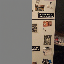
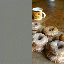
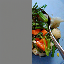
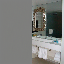
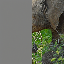
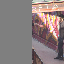
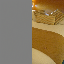
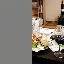
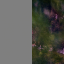

In [2]:
subject = load_subject('subj05', image_size=CONFIG['image_size'])
hyperparams = hyperparam_fn()
kfolds = make_kfolds(subject, hyperparams)
metrics, params = train_folds(kfolds, hyperparams)

In [ ]:
loader, _ = next(kfolds)
lh, rh, img = next(loader)
rng = jax.random.PRNGKey(0)
params = init(rng, lh)
pred = apply(params, rng, lh)
# loss = loss_fn(params, rng, lh, img)
# opt = optax.adam(1e-3)
# opt_state = opt.init(params)
# grads = jax.grad(loss_fn)(params, rng, lh, img)
pred.shape, img.shape

In [ ]:
pred.shape, img.shape

In [ ]:
def network_fn(z):
    conv = [hk.Conv2D(32, kernel_shape=3, stride=1, padding='SAME'), jax.nn.gelu,
            hk.Conv2D(3, kernel_shape=3, stride=1, padding='SAME'), jax.nn.gelu,]
    return hk.Sequential(conv)(z)

init, apply = hk.transform(network_fn)

In [ ]:
rng = jax.random.PRNGKey(42)
params = init(rng, pred)
apply(params, rng, pred).shape, img.shape